In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from skimage.io import imread, imshow
import pandas as pd
from sklearn.model_selection import train_test_split
import skimage

/home/wvillegas/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
use_gpu

In [ ]:
dataset = pd.read_csv(os.path.join('/home','wvillegas','dataset-mask', 'full_masks.csv'))
root_dir = os.path.join('/home','wvillegas','dataset-mask')

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset['orig'],dataset['mask'],
                                                    test_size = 0.2, random_state=1)
partition = {'train':list(X_train),
             'test': list(X_test)}
img_list = list(X_train) + list(X_test)
mask_list = list(Y_train) + list(Y_test)
labels = dict(zip(img_list, mask_list))

In [ ]:
from utils_pytorch import BudMaskDataset

In [ ]:
data_train = BudMaskDataset(img_list=partition['train'], labels=labels, root_dir=root_dir)

In [ ]:
temp = data_train.__getitem__(450);

In [ ]:
class VGG11_BN_FCN(nn.Module):
    def __init__(self):
        super().__init__()
        vgg11_bn = models.vgg11_bn(pretrained=True)
        self.encoder = vgg11_bn.features
        self.decoder = nn.Sequential(nn.Conv2d(in_channels=512,out_channels=256,kernel_size=1),
                                     nn.Conv2d(in_channels=256,out_channels=1,kernel_size=1),
                                     nn.ConvTranspose2d(in_channels=1,out_channels=1, kernel_size=16, stride=8),
                                     nn.ConvTranspose2d(in_channels=1,out_channels=1, kernel_size=4, stride=2),
                                     nn.ConvTranspose2d(in_channels=1,out_channels=1, kernel_size=4, stride=2))
        
    def forward(self, x):
        x = self.encoder.forward(x)
#         print(x.shape)
        x = self.decoder.forward(x)
#         print(x.shape)
        return x
            #return self.encoder.forward(x)

In [ ]:
fcn_encoder = VGG11_BN_FCN()

In [ ]:
# fcn_encoder.modules

In [ ]:
fcn_encoder = fcn_encoder.cuda()

In [ ]:
img = temp['image']

In [ ]:
img.shape

In [ ]:
img = torch.unsqueeze(img,0)

In [ ]:
img = img.cuda()

In [ ]:
res = fcn_encoder.forward(img)

In [ ]:
res.shape

In [4]:
from keras.applications import MobileNet

In [5]:
net = MobileNet(include_top=False, weights=None)

In [8]:
net.load_weights('/home/wvillegas/DLProjects/BudClassifier/cmdscripts/modelosV2/mobilenet_weights_detection.h5', by_name=True)


In [13]:
img = imread(os.path.join('/home','wvillegas','dataset-mask','images','0001.jpg'))

In [16]:
img = np.expand_dims(img, axis=0)

In [17]:
img.shape

(1, 3456, 4608, 3)

In [10]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
__________

In [19]:
pred = net.predict(img)

In [20]:
pred.shape

(1, 108, 144, 1024)

/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


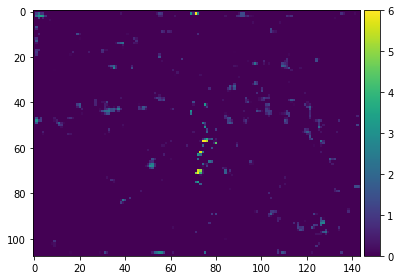

In [31]:
imshow(pred[0,:,:,900])